# Sliced Inverse Regression vs. Principal Component Analysis 
### By: Tanmay Kenjale

## Background

The Principal Component Analysis (PCA) and Sliced Inverse Regression (SIR) are both dimension reduction techniques. This means that they both seek to reduce the number of predictor variables in a dataset while maintaining information in the dataset. Dimension reduction can reduce computation times when modeling and also improve model performance. 

The way that PCA and SIR go about dimension reduction is both similar and difference. First of all, they are both ***feature extraction*** methods rather than ***feature elimination*** methods. The techniques do not eliminate any of the original predictor variables. Instead, they create new predictors by taking different combinations of the original predictors. The number of new predictors equals the number of original predictors. The new predictors are also ordered from most important to least important, which allows us to keep only the important predictors in further analysis, which effectively reduces the dimension of the dataset. The benefit of feature extraction is that information from all of the original predictors is maintained. The consequence is that each new predictor is harder to interpret. The major difference between PCA and SIR is that PCA attempts to maximize the variation within the predictor variables, while SIR attempts to maximize the variation in the response variable. PCA gives no consideration to the response variable, making it an ***unsupervised*** technique. SIR is a ***supervised*** technique.

This notebook uses simulated data to highlight the advantages of the Sliced Inverse Regression (SIR) over the Principal Component Analysis (PCA) in a regression problem. We will also show that while SIR has the potential to perform much better than PCA, it also has the potential to fail in certain situations.

## Import Libraries

In [1]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from sklearn.decomposition import PCA 
from sliced import SlicedInverseRegression

## Define Plotting Functions

In [14]:
def plot2D(data, x, y, color=None, width=600, height=600, marker_size=7, color_sequence=None, range_x=None, range_y=None, title=None, x_title=None, y_title=None):
    fig = px.scatter(data,  x=x, y=y, color=color, color_discrete_sequence=color_sequence, range_x=range_x, range_y=range_y, title=title)
    fig.update_traces(marker_size = marker_size)
    fig.update_layout(
        width=width,
        height=height,
        xaxis_title=x_title,
        yaxis_title=y_title
    )
    fig.show()

In [15]:
def plot3D(data, x, y, z, color, width=800, height=800, marker_size=4, color_sequence=None, x_title='', y_title='', z_title='', title=None):
    fig = px.scatter_3d(data, x=x, y=y, z=z, color=color, color_discrete_sequence=color_sequence, title=title)
    fig.update_traces(marker_size = marker_size)
    fig.update_layout(
        scene_aspectmode='cube',
        width=width,
        height=height,
        legend=dict(
            x=1,
            y=0.5,
            font=dict(size= 20), 
            itemsizing="constant"
        ),
        scene = dict(
            xaxis_title=x_title,
            yaxis_title=y_title,
            zaxis_title=z_title
        )
    )
    fig.show()

# Initial Analysis of Linear Data

We will first conduct PCA and SIR on a simulated dataset that contains 10 randomly-generated predictor variables $X_{1...10}$ and 1 response variable $Y$. <br>
The response variable was generated by the following formula: $Y = X_{1} + X_{2} + \epsilon$ , where $\epsilon$ is an error term. <br>
Out of the 10 predictors, 2 predictors are interacting to form a linear relationship with $Y$. We will attempt to use PCA and SIR to find just one predictor that can capture the linear relationship with $Y$.

In [16]:
# Import simulated linear data
linear_data = pd.read_csv("data/linear_data.csv")
linear_data.columns = ["X" + str(num) for num in np.arange(1, 11)] + ["Y"]
linear_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,-7.196576,8.703507,-0.968103,-7.254550,-5.915241,-5.399486,-5.046725,-5.270388,3.498594,-1.354305,5.481404
1,-9.178779,9.957589,6.781680,-9.953429,-9.685889,-6.307880,0.577356,0.752508,-5.087280,8.474593,-3.394049
2,9.970844,6.044510,-6.134466,4.394076,-4.820899,-7.528039,1.690147,-3.139101,2.011753,-2.531146,20.664276
3,8.458323,7.971192,8.743728,-7.408277,2.555352,0.579282,1.438180,-4.026889,-0.091994,8.222818,15.051567
4,3.281797,6.715029,5.285356,7.977959,2.794019,8.204651,7.987363,-3.552845,9.550773,9.244328,10.509343


## Plot $X_1$ vs. $X_2$

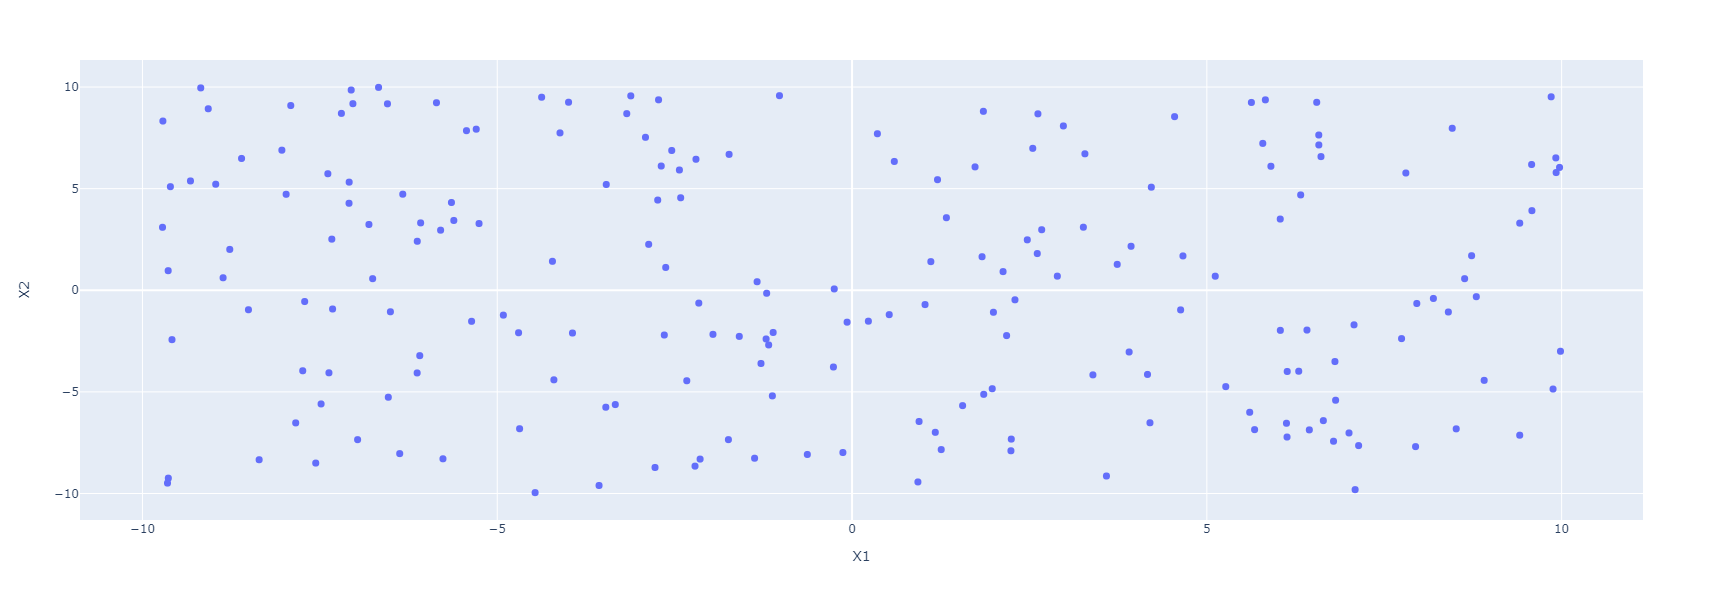

In [17]:
plot2D(linear_data, x="X1", y="X2", x_title="X1", y_title="X2", title="")

We can see that the relationship between $X_1$ and $X_2$ is completely random. This is an indicator that PCA will not perform well because PCA depends on the relationships within the predictor variables.

## Plot $X_1$ vs. $X_2$ vs. $Y$

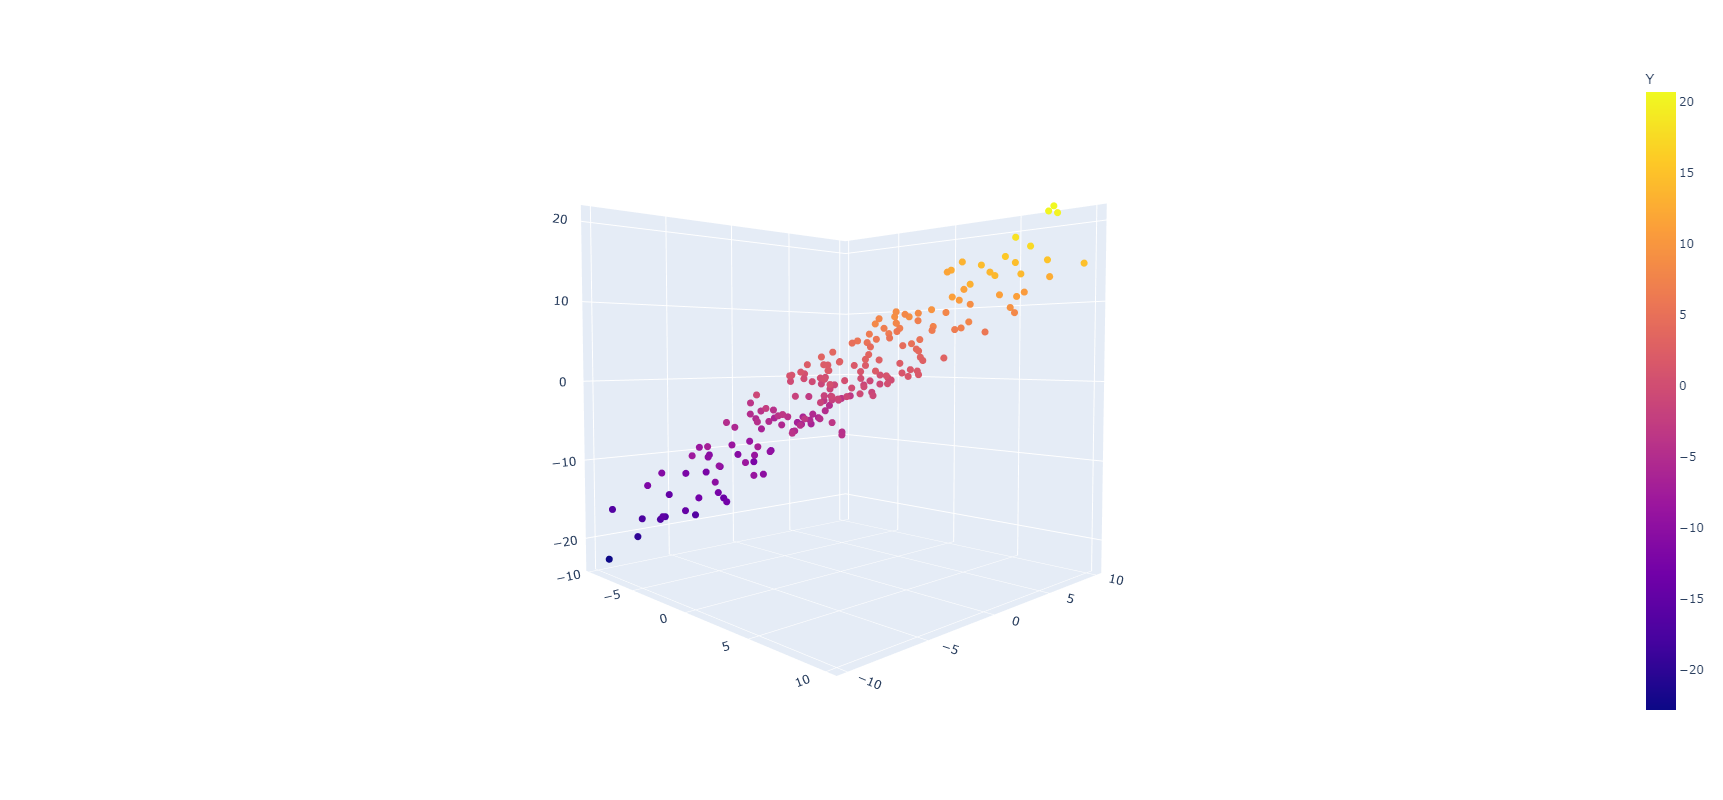

In [6]:
plot3D(linear_data, x="X1", y="X2", z="Y", color="Y")#, x_title="X1", y_title="X2", z_title="Y")

The relationship between the two predictor variables and the response variable is linear in nature. SIR should be able to capture this relationship with just one variable. 

## Principal Component Analysis (PCA)

We will find out if PCA can create one predictor variable that is able to form a linear relationship with $Y$.

In [7]:
# Split data into X and Y
X = linear_data.iloc[:, :10]
Y = linear_data.Y

In [8]:
# Conduct PCA
pca = PCA(n_components = 1)
linear_data["PC1"] = pca.fit_transform(X)

### Plot the First Principal Component Against $Y$

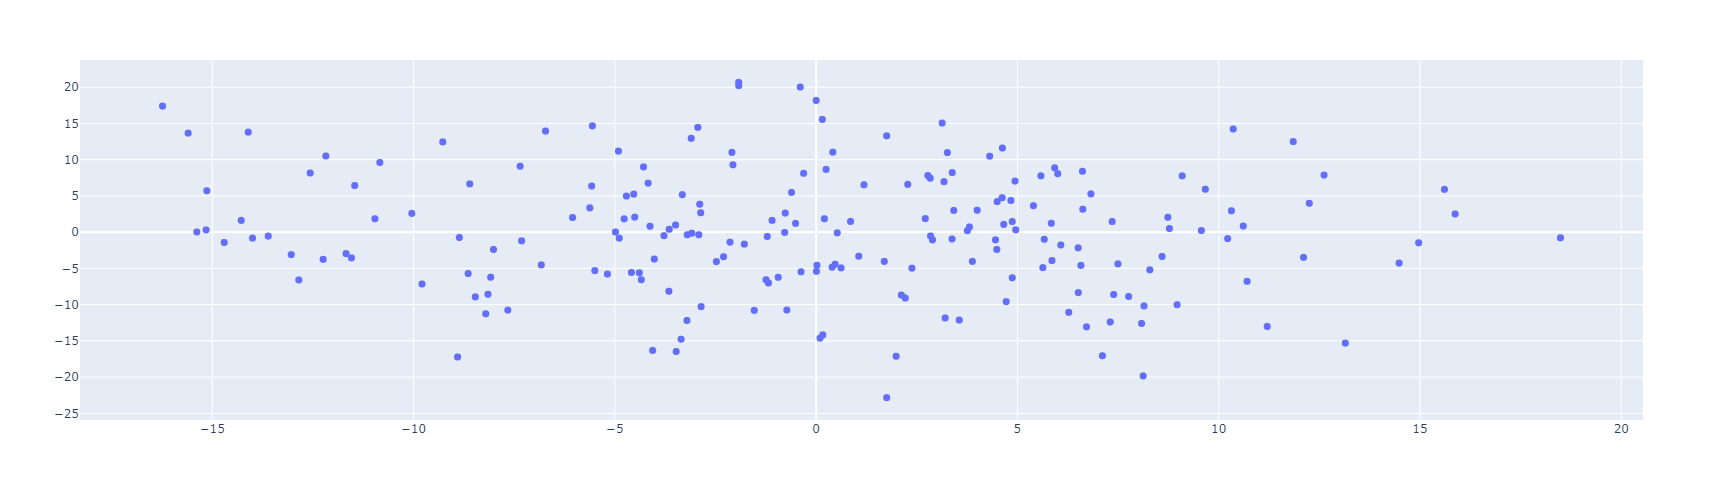

In [10]:
plot2D(linear_data, x="PC1", y="Y")#, x_title="PC1", y_title="Y")

As we can see, the first Principal Component is not able to capture the linear relationship with $Y$. Instead, $PC_1$ has no relationship with $Y$. 

## Sliced Inverse Regression (SIR)

We will find out if SIR can create one predictor variable that is able to form a linear relationship with $Y$.

SIR sorts the data by $Y$ in ascending order. It then slices the data into multiple partitions, each of which contains data points corresponding to a range of $Y$. 

In [11]:
# Sort data in ascending order by Y value
linear_data_sorted = linear_data.sort_values(by="Y")

# Assign 4 slices to the data
slice_distribution = [35, 65, 65, 35] # first 35 data points are assigned to the 1st slice, next 65 data points are assigned to the 2nd slice, etc. For visualization purposes.
linear_data_sorted["slice"] = np.repeat(["1", "2", "3", "4"], slice_distribution)
linear_data_sorted.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y,PC1,slice
84,-9.647241,-9.487698,6.768416,5.411901,-2.575307,5.952633,-6.108615,-8.995494,-1.376370,-3.284502,-22.831426,1.753056,1
97,-8.355872,-8.338309,-2.311717,-8.299630,9.274040,-4.532209,-3.978175,-9.037134,-0.423697,1.524134,-19.838109,8.123933,1
161,-7.558231,-8.502846,-2.581760,4.530940,-7.089801,6.130985,7.038211,0.889524,-4.185807,7.160260,-17.223529,-8.905616,1
135,-6.968008,-7.350961,-6.153650,-4.404948,6.178465,0.967169,0.375739,-6.972628,-6.784122,2.878531,-17.127142,1.987986,1
146,-6.374665,-8.037492,5.100321,-6.441201,-0.670633,-8.485511,-4.082568,1.792938,-5.215996,8.249352,-17.054427,7.112104,1


### Plot of the Data Silced by $Y$

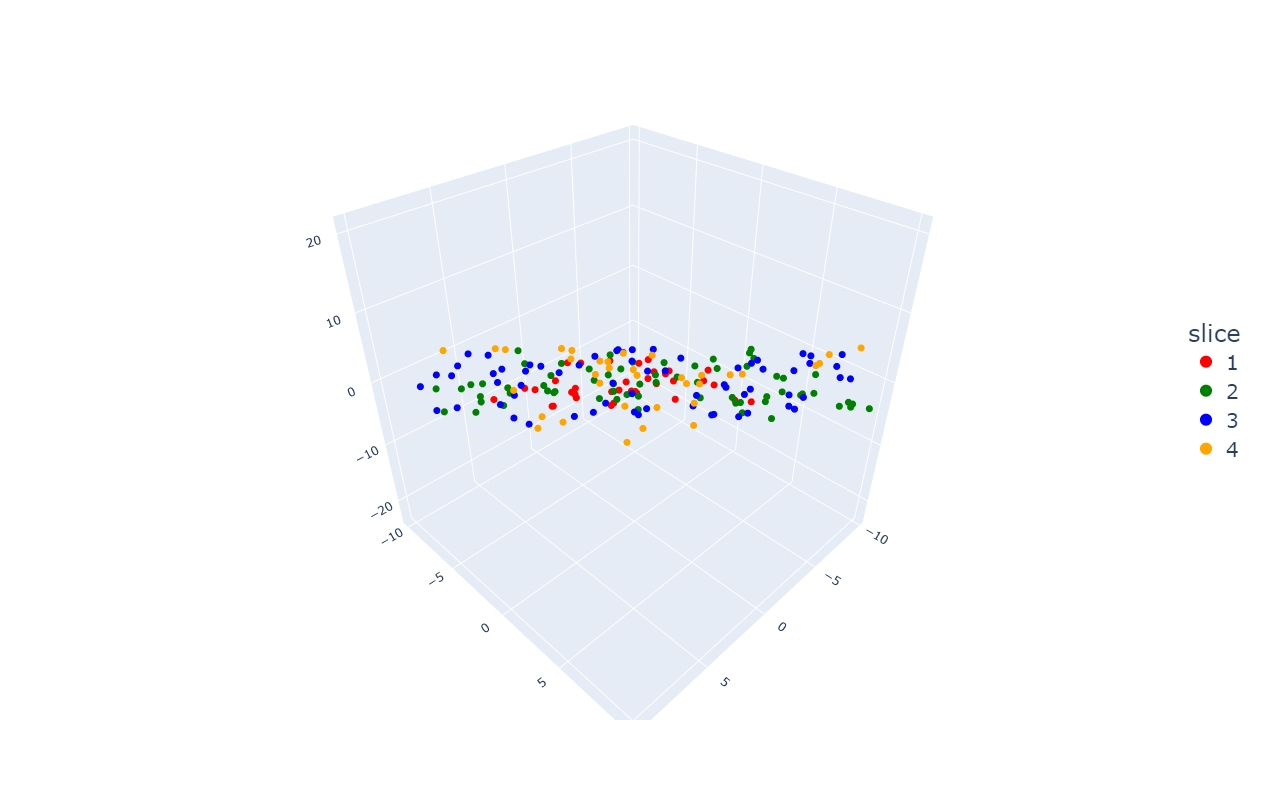

In [12]:
plot3D(linear_data_sorted, x="X1", y="X2", z="Y", color="slice", color_sequence=["red", "green", "blue", "orange"])#, x_title="X1", y_title="X2", z_title="Y")

### Average the $X$ Values Within Each Slice

In [121]:
# Group data by slice and average
linear_data_mean = linear_data_sorted.groupby("slice").mean()
linear_data_mean["slice"] = [str(num) for num in np.arange(1, 5)]

### Plot the Average Values of $X_1$ and $X_2$

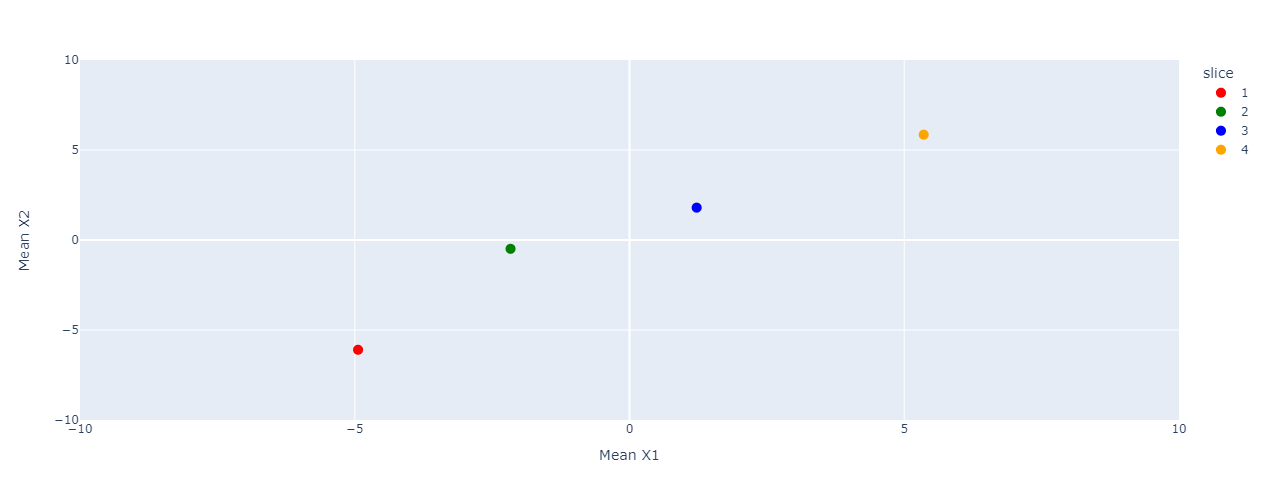

In [122]:
plot2D(linear_data_mean, x="X1", y="X2", color="slice", marker_size=10, color_sequence=["red", "green", "blue", "orange"], range_x=[-10, 10], range_y=[-10, 10], x_title="Mean X1", y_title="Mean X2")

### Perform SIR

SIR performs a Principal Component Analysis on the slice means to form new predictor variables.

In [134]:
sir = SlicedInverseRegression(n_directions=1)
linear_data["SIR1"] = sir.fit_transform(X, Y)

### Plot the First SIR Component Against $Y$

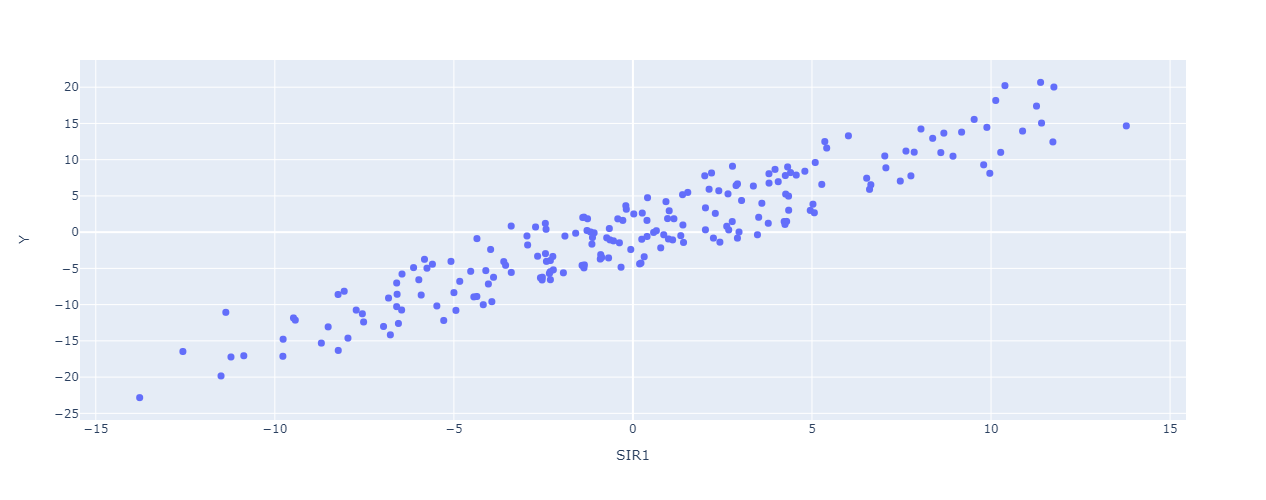

In [135]:
plot2D(linear_data, x="SIR1", y="Y", x_title="SIR1", y_title="Y")

SIR is able to capture the linear relationship with $Y$ with just one variable. We have effectively reduced the dimensionality of $X$ while maintaining regression performance.

# The Limitations of SIR

SIR depends on using the slice means to perform dimension reduction. What happens when most of the slice means are zero or close to zero? In this scenario, SIR will not be able to perform well. This can occur when the data is symmetric on the $Y$ axis.

## Symmetrical Data

We will now conduct PCA and SIR on a simulated dataset that contains 10 randomly-generated predictor variables $X_{1...10}$ and 1 response variable $Y$. <br>
The response variable was generated by the following formula: $Y = (X_{1} + X_{2})^2 + \epsilon$ , where $\epsilon$ is an error term. <br>
Out of the 10 predictors, 2 predictors are interacting to form a quadratic relationship with $Y$. We will attempt to use PCA and SIR to find just one predictor that can capture the quadratic relationship with $Y$.

In [9]:
symmetric_data = pd.read_csv("data/symmetric_data.csv")
symmetric_data.columns = ["X" + str(num) for num in np.arange(1, 11)] + ["Y"]
symmetric_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,-7.725932,3.215093,3.724845,-4.380564,-7.801079,6.752678,2.460830,3.508203,-6.941330,-9.959475,34.483919
1,2.445988,0.567188,-1.667426,-6.516237,7.428736,-0.250675,-3.182398,1.866613,-1.992819,2.943208,22.851924
2,2.185495,-3.650124,5.140525,-6.595511,0.288395,-7.793260,4.597754,8.459644,-8.347565,-3.302874,7.877298
3,2.467589,5.357109,5.515897,1.210873,-4.286024,-2.972740,-5.469372,6.035057,3.153487,-2.795765,79.473114
4,7.218308,0.526170,1.471740,-1.423988,-3.265320,5.221261,-9.091791,-1.655449,-0.392569,-8.630925,79.007511


## Plot $X_1$ vs. $X_2$

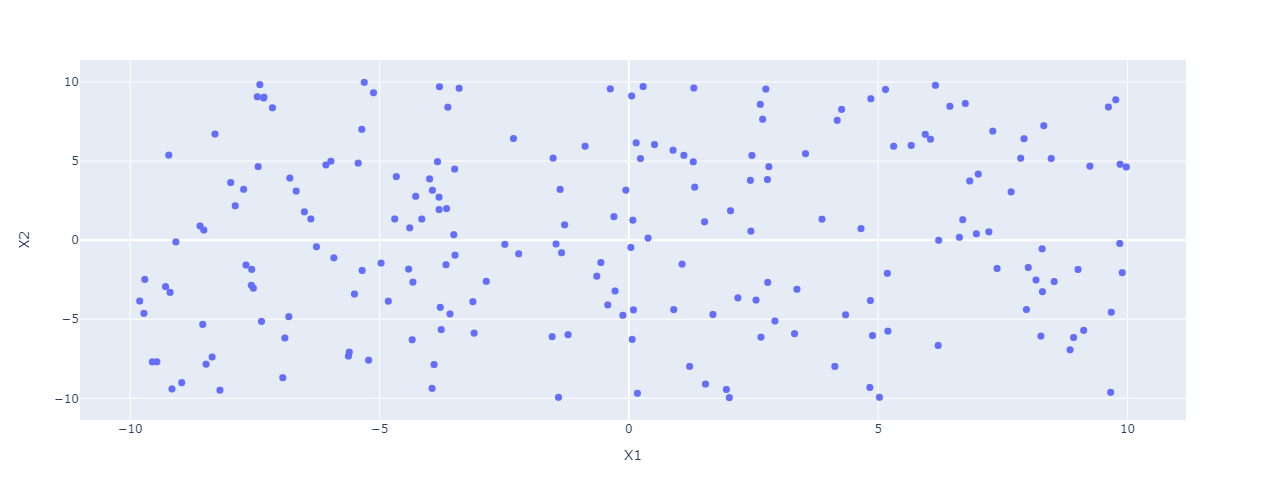

In [125]:
plot2D(symmetric_data, x="X1", y="X2", x_title="X1", y_title="X2")

Like the first example, our first two predictors are uncorrelated.

### Plot $X_1$ vs. $X_2$ vs. $Y$

In [126]:
plot3D(symmetric_data, x="X1", y="X2", z="Y", color="Y", x_title="X1", y_title="X2", z_title="Y")

The relationship between the two predictor variables and the response variable is quadratic in nature. This is a symmetric relationship. 

### Principal Component Analysis (PCA)

In [56]:
# Split symmetric data into X and Y
X_symmetric = symmetric_data.iloc[:, :10]
Y_symmetric = symmetric_data.Y

In [58]:
# Conduct PCA
pca2 = PCA(n_components = 1)
symmetric_data["PC1"] = pca2.fit_transform(X_symmetric)

#### Plot the First Principal Component Against $Y$

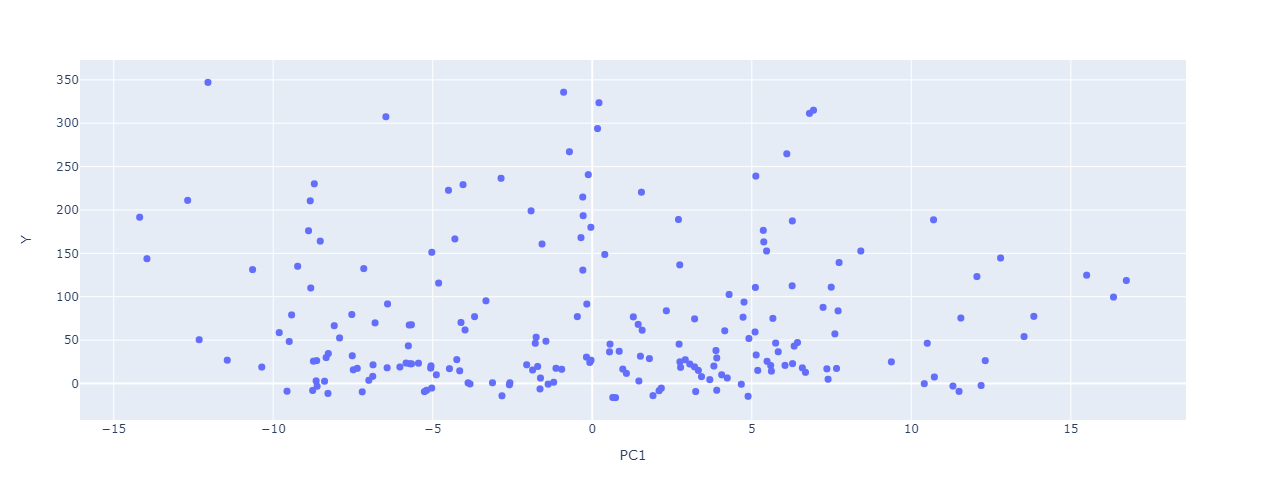

In [129]:
plot2D(symmetric_data, x="PC1", y="Y", x_title="PC1", y_title="Y")

As expected, the first Principal Component is not able to capture the quadratic relationship with $Y$. Instead, $PC_1$ has no relationship with $Y$.

### Sliced Inverse Regression (SIR)

In [127]:
# Sort data by Y and create three slices
symmetric_data_sorted = symmetric_data.sort_values(by="Y")
symmetric_data_sorted["slice"] = np.repeat(["1", "2", "3"], [80, 75, 45])
symmetric_data_sorted.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y,PC1,SIR1,slice
51,-3.806268,1.932475,5.519376,3.736707,9.534726,7.621857,-5.087589,3.807399,4.302922,0.743672,-16.327581,0.730442,10.153279,1
194,6.201668,-6.659074,-2.861596,4.099980,3.873656,5.894442,-2.382977,-4.123334,-0.540315,3.707170,-16.189219,0.643839,4.111698,1
35,5.193413,-5.755181,3.180581,6.690232,3.508784,-4.944957,7.558085,-6.031684,7.291132,3.044761,-14.828602,4.884071,-1.922729,1
166,-1.379673,3.210299,5.841733,8.541055,3.253026,-0.852272,-5.453507,3.804111,6.550116,1.165722,-14.198883,-2.829780,4.050655,1
79,3.369908,-3.107254,-7.158529,9.003974,1.553022,-1.885836,6.786466,3.251316,-7.237726,3.144786,-14.023303,1.904449,1.366360,1


#### Plot of Data Sliced by $Y$

In [130]:
plot3D(symmetric_data_sorted, x="X1", y="X2", z="Y", color="slice", color_sequence=["red", "green", "blue"], x_title="X1", y_title="X2", z_title="Y")

#### Average the $X$ Values Within Each Slice

In [96]:
symmetric_data_mean = symmetric_data_sorted.groupby("slice").mean()
symmetric_data_mean["slice"] = [str(num) for num in np.arange(1, 4)]

#### Plot the Average Values of $X_1$ and $X_2$

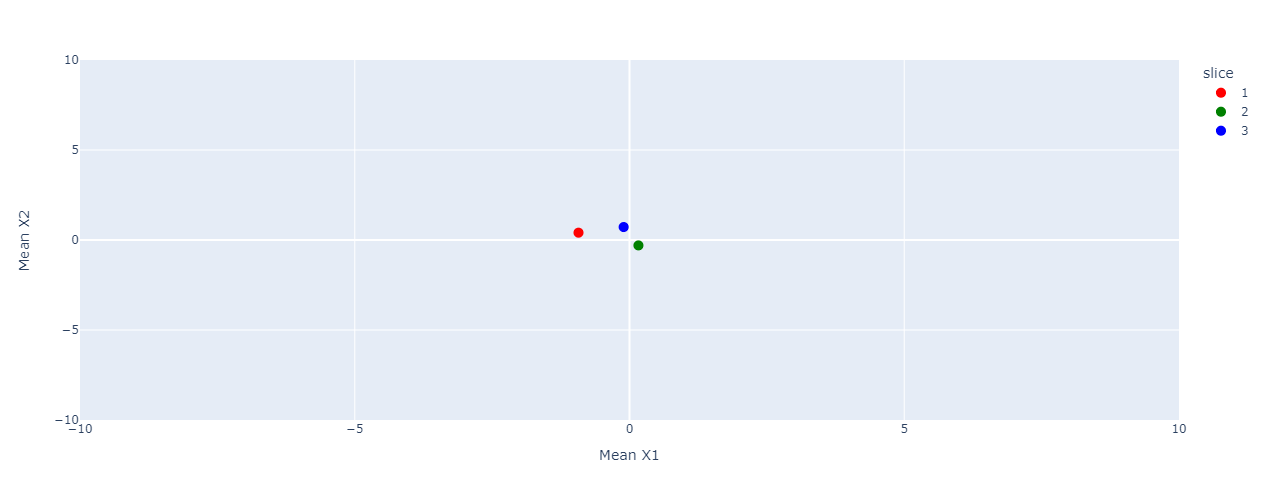

In [131]:
plot2D(symmetric_data_mean, x="X1", y="X2", color="slice", marker_size=10, color_sequence=["red", "green", "blue"], range_x=[-10, 10], range_y=[-10, 10], x_title="Mean X1", y_title="Mean X2")

These averages are very close to zero and therefore do not provide much information about the relationship with $Y$.

#### Perform SIR

In [98]:
sir2 = SlicedInverseRegression(n_directions=1)
symmetric_data["SIR1"] = sir2.fit_transform(X_symmetric, Y_symmetric)

#### Plot the First SIR Component against $Y$

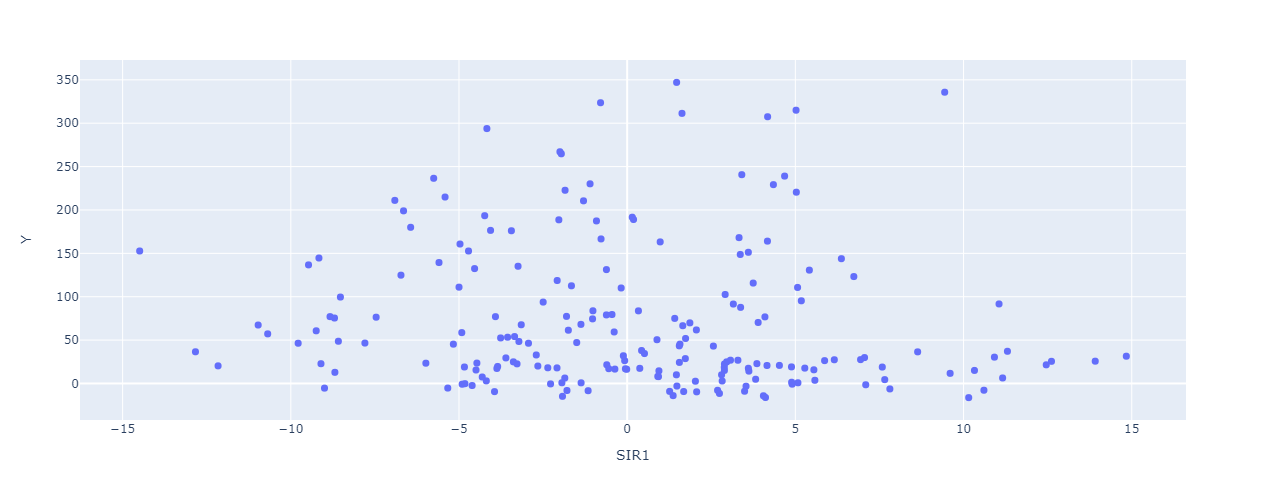

In [132]:
plot2D(symmetric_data, x="SIR1", y="Y", x_title="SIR1", y_title="Y")

The first component of SIR does not capture the quadratic relationship with $Y$. SIR will not work with highly symmetrical data. Consider other options such as the Sliced Average Variance Estimation (SAVE) or the Kernel Sliced Inverse Regression (KSIR).